In [1]:
from pathlib import Path
from itertools import chain

import numpy as np

from run_benchmarks import read_benchmark

/home/jwburns/miniconda3/envs/fpbench/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
benchmark = "SingleAssay"

In [3]:
unique_smiles = set()
series_to_plot = []
for repetition in range(1000):
    filename = Path(f"{benchmark}/{benchmark}/dataset/{repetition}.txt")
    smiles_series = read_benchmark(filename)
    if repetition < 4:
        series_to_plot.append(smiles_series[123])
    unique_smiles.update(chain.from_iterable(smiles_series))


In [4]:
# manually selected
series_to_plot = [
    ['c1cc(-c2ccc3c(c2)OCO3)ccc1OCCCN1CCCCC1', 'c1csc(-c2ccc(OCCCN3CCCCC3)cc2)c1', 'COc1ccccc1-c1ccc(OCCCN2CCCCC2)cc1', 'Cn1nccc1-c1ccc(OCCCN2CCCCC2)cc1', 'c1cc(C2CCCO2)ccc1OCCCN1CCCCC1'],
    [],
    ['CS(=O)(=O)Cc1cc(N2CCOCC2)nc(-c2ccc(NC(=O)Nc3ccc(F)cc3)cc2)n1', 'C[C@H]1COCCN1c1cc(CS(C)(=O)=O)nc(-c2ccc3[nH]ccc3c2)n1', 'O=S(=O)(Cc1cc(N2CCOCC2)nc(-c2ccccn2)n1)c1ccccc1', 'CS(=O)(=O)Cc1cc(N2CCOCC2)nc(-c2ccccc2)n1', 'COCc1cccc(-c2nc(CS(C)(=O)=O)cc(N3CCOCC3)n2)c1'],
    ['Clc1cc(Cl)cc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)c1', 'Clc1ccc(CNc2ncncc2-c2ccc3c(c2)OCO3)cc1',  'c1cncc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)c1', 'c1cncc(CNc2ccnc(-c3ccc4[nH]ncc4c3)n2)c1', 'c1cncc(CNc2ccnc(-c3ccc4cn[nH]c4c3)n2)c1'],
]

In [5]:
len(unique_smiles)

65485

In [6]:
import torch

from rdkit.Chem import MolFromSmiles

from chemprop.data import BatchMolGraph
from chemprop.nn.agg import MeanAggregation
from chemprop.nn import RegressionFFN
from chemprop.featurizers import SimpleMoleculeMolGraphFeaturizer
from chemprop.models import MPNN

In [7]:
chemeleon = MPNN(
    message_passing=torch.load(Path("benchlib/chemeleon_mp.pt"), map_location="cpu", weights_only=False),
    agg=MeanAggregation(),  # matches original chemeleon training
    predictor=RegressionFFN(),  # not actually used
)
chemeleon.eval()
chemeleon.to(device="cuda:0")
chemeleon_feat = SimpleMoleculeMolGraphFeaturizer()

@torch.no_grad
def chemeleon_fingerprint(smiles: str):
    bmg = BatchMolGraph([chemeleon_feat(MolFromSmiles(smiles))])
    bmg.to(device="cuda:0")
    return chemeleon.fingerprint(bmg).numpy(force=True).flatten()

In [8]:
unique_smiles = list(unique_smiles)

In [9]:
chemeleon_embeddings = np.array(list(map(chemeleon_fingerprint, unique_smiles)))

In [10]:
chemeleon_embeddings.shape

(65485, 2048)

In [11]:
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io
import random

In [12]:
def preservation_scorer(X_orig, X_embedded):
    nbrs_orig = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(X_orig)
    indices_orig = nbrs_orig.kneighbors(X_orig, return_distance=False)
    nbrs_emb = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(X_embedded)
    indices_emb = nbrs_emb.kneighbors(X_embedded, return_distance=False)
    
    # Compute preservation fraction
    preservation = 0
    for i in range(X_orig.shape[0]):
        orig_nbrs = set(indices_orig[i])
        emb_nbrs = set(indices_emb[i])
        preservation += len(orig_nbrs.intersection(emb_nbrs)) / 20
    return preservation / X_orig.shape[0]


In [13]:
# Custom scorer for GridSearchCV
def custom_scorer(estimator, X, y=None):
    X_embedded = estimator.fit_transform(X)
    return preservation_scorer(X, X_embedded)


In [14]:
class TSNEWrapper:
    def __init__(self, perplexity=30):
        self.perplexity = perplexity
        self.tsne = None
    
    def fit(self, X, y=None):
        self.tsne = TSNE(
            n_components=2,
            perplexity=self.perplexity,
            learning_rate='auto',
            early_exaggeration=12,
            random_state=42,
            n_jobs=-1
        )
        self.tsne.fit_transform(X)  # Fit the model
        return self
    
    def fit_transform(self, X, y=None):
        if self.tsne is None:
            self.fit(X)
        return self.tsne.fit_transform(X)
    
    def get_params(self, deep=True):
        return {'perplexity': self.perplexity}
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        self.tsne = None  # Reset tsne to ensure new parameters are used
        return self


In [15]:
# Step 1: Subsample for hyperparameter optimization
sample_size = 5000
indices = random.sample(range(chemeleon_embeddings.shape[0]), sample_size)
X_sample = chemeleon_embeddings[indices]

# Step 2: Hyperparameter grid for t-SNE
param_grid = {'perplexity': [5, 10, 20, 30, 50]}

# Step 4: Perform grid search on subsample
tsne_wrapper = TSNEWrapper()
grid_search = GridSearchCV(
    estimator=tsne_wrapper,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    n_jobs=1,
)
grid_search.fit(X_sample)

# Best parameters
best_params = grid_search.best_params_
print("Best perplexity:", best_params['perplexity'])
print("Best preservation fraction (on subsample):", grid_search.best_score_)


Best perplexity: 30
Best preservation fraction (on subsample): 0.36448060928030457


In [16]:
# Step 5: Apply t-SNE with best perplexity to full dataset
tsne = TSNE(
    n_components=2,
    perplexity=best_params['perplexity'],
    learning_rate='auto',
    early_exaggeration=12,
    random_state=42,
    n_jobs=-1
)
X_2d = tsne.fit_transform(chemeleon_embeddings)

# Step 6: Compute preservation fraction on full dataset
preservation_fraction = preservation_scorer(chemeleon_embeddings, X_2d)
print("Preservation fraction (full dataset):", preservation_fraction)


Preservation fraction (full dataset): 0.6942307398640908


In [17]:
from rdkit.Chem.Descriptors import ExactMolWt

In [18]:
projected_lookup = {smi: coords for smi, coords in zip(unique_smiles, X_2d)}
weight_lookup = list(map(lambda smi: ExactMolWt(MolFromSmiles(smi)), unique_smiles))

In [19]:
X_2d.shape

(65485, 2)

In [56]:
from matplotlib import transforms

/tmp/ipykernel_3624852/1099104102.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(ticklabels)


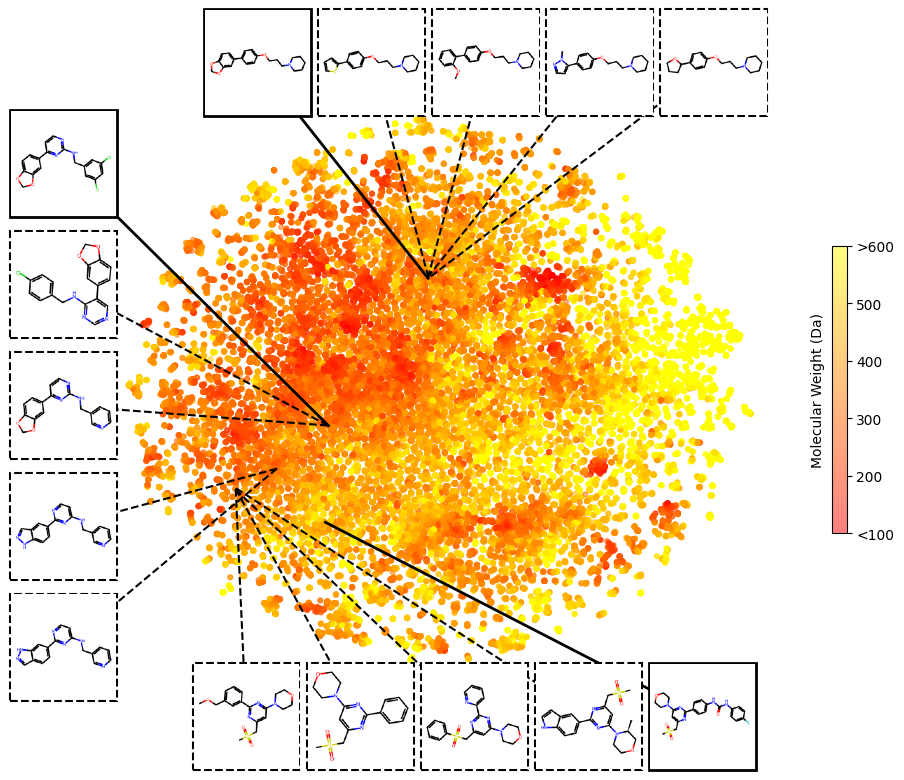

In [63]:
# Step 7: Plotting
plt.figure(figsize=(10, 8))
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(0)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=12, alpha=0.5, c=weight_lookup, cmap='autumn', transform=rot + base)

# Get plot limits to position images relative to the plot
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
increment = (x_max - x_min) / 6
x_min *= 1.1
x_max *= 1.1
y_min *= 1.1
y_max *= 1.1

# Calculate position for images (right side of the plot)
# image_x_position = x_max + plot_margin
# Step 8: Add callouts for series_to_plot
for series_number, series in enumerate(series_to_plot):
    if series_number == 0:  # top left
        x = x_min + increment * 1.7
        x_increment = increment
        y = y_max
        y_increment = 0.0
    elif series_number == 1:  # top right
        x = x_max
        x_increment = 0.0
        y = y_max - increment
        y_increment = -increment
    elif series_number == 2:  # bottom right
        x = x_max - increment
        x_increment = -increment
        y = y_min
        y_increment = 0.0
    elif series_number == 3:  # bottom left
        x = x_min
        x_increment = 0.0
        y = y_max - increment
        y_increment = - increment*1.2

    for smiles_number, smiles in enumerate(series):
        embedding_2d = projected_lookup[smiles]
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES: {smiles}")
            continue
        img = Draw.MolToImage(mol, size=(150, 150))
        img_buffer = io.BytesIO()
        img.save(img_buffer, format="PNG")
        img_buffer.seek(0)
        img_arr = plt.imread(img_buffer)
        if smiles_number == 0:
            linestyle='-'
            color = 'k'
            width = 2
        else:
            linestyle = '--'
            color = 'k'
            width = 1.5

        # Add image as callout on the right, stacked vertically
        imagebox = OffsetImage(img_arr, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), 
                            frameon=True, pad=0.1,
                            bboxprops=dict(facecolor='white', linestyle=linestyle, linewidth=width),
                            boxcoords="data",
                            xycoords="data", transform=rot + base)
        plt.gca().add_artist(ab)
        
        # Draw a line from the image to the corresponding point
        plt.plot([embedding_2d[0], x], 
                [embedding_2d[1], y], color + linestyle, linewidth=width, transform=rot + base)
        
        x += x_increment
        y += y_increment

plt.clim(100, 600)
cbar = plt.colorbar(shrink=0.4, location="right")
cbar.set_label('Molecular Weight (Da)', rotation=90, labelpad=5)
ticklabels = list(map(lambda t: str(int(t)), cbar.get_ticks()))
ticklabels[0] = "<" + ticklabels[0]
ticklabels[-1] = ">" + ticklabels[-1]
cbar.set_ticklabels(ticklabels)

# Set the label's position to the center on the left side
cbar.ax.yaxis.set_label_position('left')  # Move the label to the left of the colorbar
cbar.ax.yaxis.label.set_position((-0.1, 0.5))  # Move label to the center vertically

plt.axis('off')
plt.tight_layout()
plt.savefig(Path(f"results/{benchmark}_projection.png"), dpi=600)
plt.show()

Some interesting series to plot for single assay:
 - for the left, shows the separation of methylenedioxy functional group: `['Clc1cc(Cl)cc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)c1',  'c1cncc(CNc2nccc(-c3ccc4c(c3)OCO4)n2)c1', 'c1cncc(CNc2ccnc(-c3ccc4[nH]ncc4c3)n2)c1', 'c1cncc(CNc2ccnc(-c3ccc4cn[nH]c4c3)n2)c1', 'Clc1ccc(CNc2ncncc2-c2ccc3c(c2)OCO3)cc1']`
 - for the top, shows a nice steady change in one fuctional group being mapped as we expect: `['c1cc(-c2ccc3c(c2)OCO3)ccc1OCCCN1CCCCC1', 'c1csc(-c2ccc(OCCCN3CCCCC3)cc2)c1', 'COc1ccccc1-c1ccc(OCCCN2CCCCC2)cc1', 'Cn1nccc1-c1ccc(OCCCN2CCCCC2)cc1', 'c1cc(C2CCCO2)ccc1OCCCN1CCCCC1']`
 - for the bottom, shows an interesting case where the 'lead compounds' isn't actually that close in chemical space: `['CS(=O)(=O)Cc1cc(N2CCOCC2)nc(-c2ccc(NC(=O)Nc3ccc(F)cc3)cc2)n1', 'C[C@H]1COCCN1c1cc(CS(C)(=O)=O)nc(-c2ccc3[nH]ccc3c2)n1', 'O=S(=O)(Cc1cc(N2CCOCC2)nc(-c2ccccn2)n1)c1ccccc1', 'CS(=O)(=O)Cc1cc(N2CCOCC2)nc(-c2ccccc2)n1', 'COCc1cccc(-c2nc(CS(C)(=O)=O)cc(N3CCOCC3)n2)c1']`